# Vanilla GAN for MNIST (PyTorch)

In [16]:
% matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

if torch.cuda.is_available():
    import torch.cuda as t
else:
    import torch as t

from torchvision import datasets, models, transforms, utils
import torchvision.utils as vutils

import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
import os

## mnist datasetの準備

In [17]:
bs = 100

In [18]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=bs
)

## Model

In [19]:
'''Discriminater'''
class netD(nn.Module):
    def __init__(self):
        super(netD, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Linear(300, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        x = self.main(x)
        return x

'''Generator'''
class netG(nn.Module):
    def __init__(self):
        super(netG, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(bs,100)
        x = self.main(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [20]:
criteion = nn.BCELoss()
net_D = netD()
net_G = netG()

if torch.cuda.is_available():
    D = net_D.cuda()
    G = net_G.cuda()
    criteion = criteion.cuda()    

In [21]:
optimizerD = optim.Adam(net_D.parameters(), lr = 1e-4)
optimizerG = optim.Adam(net_G.parameters(), lr = 1e-4)

## Train

In [22]:
input = t.FloatTensor(bs, 1, 28, 28)
noise = t.FloatTensor(uniform(0,1,(bs, 100, 1, 1)))
fixed_noise = t.FloatTensor(bs, 100, 1, 1).normal_(0, 1)
label = t.FloatTensor(bs)

real_label = 1
fake_label = 0

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)

In [23]:
niter = 4000

In [24]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real (data)
        net_D.zero_grad()
        real, _ = data
        input.data.resize_(real.size()).copy_(real)
        label.data.resize_(bs).fill_(real_label)

        output = net_D(input)
        errD_real = criteion(output, label)
        errD_real.backward()
        D_x = output.data.mean()

        #train with fake (generated)
        noise.data.resize_(bs, 100, 1, 1)
        noise.data.normal_(0, 1)
        fake = net_G(noise)
        label.data.fill_(fake_label)
        output = net_D(fake.detach())
        errD_fake = criteion(output, label)
        errD_fake.backward()
        D_G_z1 = output.data.mean()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_G.zero_grad()
        label.data.fill_(real_label)
        output = net_D(fake)
        errG = criteion(output, label)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                 % (epoch, niter, i, len(dataloader),
                   errD.data[0], errG.data[0],  D_x, D_G_z1, D_G_z2))
    if epoch % 10 == 0:
        fake = net_G(fixed_noise)
        vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png'
                              % ('results', epoch),normalize=True)

[0/4000][0/600] Loss_D: 1.3774 Loss_G: 0.7734 D(x): 0.4849 D(G(z)): 0.4798 / 0.4614
[0/4000][100/600] Loss_D: 0.4435 Loss_G: 2.5407 D(x): 0.7520 D(G(z)): 0.1298 / 0.0979
[0/4000][200/600] Loss_D: 0.3307 Loss_G: 2.3395 D(x): 0.8486 D(G(z)): 0.1452 / 0.0966
[0/4000][300/600] Loss_D: 0.2424 Loss_G: 3.3446 D(x): 0.8489 D(G(z)): 0.0564 / 0.0354
[0/4000][400/600] Loss_D: 0.0658 Loss_G: 4.1486 D(x): 0.9686 D(G(z)): 0.0284 / 0.0162
[0/4000][500/600] Loss_D: 0.0548 Loss_G: 4.4317 D(x): 0.9709 D(G(z)): 0.0225 / 0.0120
[1/4000][0/600] Loss_D: 0.0952 Loss_G: 4.8037 D(x): 0.9463 D(G(z)): 0.0218 / 0.0084
[1/4000][100/600] Loss_D: 0.0744 Loss_G: 5.2767 D(x): 0.9725 D(G(z)): 0.0189 / 0.0054
[1/4000][200/600] Loss_D: 0.1847 Loss_G: 4.5582 D(x): 0.9241 D(G(z)): 0.0299 / 0.0110
[1/4000][300/600] Loss_D: 0.0385 Loss_G: 4.9896 D(x): 0.9814 D(G(z)): 0.0149 / 0.0069
[1/4000][400/600] Loss_D: 0.0217 Loss_G: 4.8109 D(x): 0.9934 D(G(z)): 0.0147 / 0.0084
[1/4000][500/600] Loss_D: 0.0118 Loss_G: 5.6721 D(x): 0.99

[16/4000][0/600] Loss_D: 0.0010 Loss_G: 8.5918 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[16/4000][100/600] Loss_D: 0.0002 Loss_G: 9.4420 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[16/4000][200/600] Loss_D: 0.0243 Loss_G: 8.0666 D(x): 0.9909 D(G(z)): 0.0009 / 0.0006
[16/4000][300/600] Loss_D: 0.0016 Loss_G: 8.6173 D(x): 0.9999 D(G(z)): 0.0014 / 0.0013
[16/4000][400/600] Loss_D: 0.0006 Loss_G: 9.5689 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[16/4000][500/600] Loss_D: 0.0007 Loss_G: 8.7949 D(x): 1.0000 D(G(z)): 0.0007 / 0.0003
[17/4000][0/600] Loss_D: 0.0001 Loss_G: 11.7579 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[17/4000][100/600] Loss_D: 0.0020 Loss_G: 7.7364 D(x): 1.0000 D(G(z)): 0.0020 / 0.0012
[17/4000][200/600] Loss_D: 0.0007 Loss_G: 8.1546 D(x): 1.0000 D(G(z)): 0.0007 / 0.0004
[17/4000][300/600] Loss_D: 0.0003 Loss_G: 9.7369 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[17/4000][400/600] Loss_D: 0.0001 Loss_G: 10.2959 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[17/4000][500/600] Loss_D: 0.0041 Loss_G: 8.0

[31/4000][400/600] Loss_D: 0.0000 Loss_G: 13.3206 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[31/4000][500/600] Loss_D: 0.0001 Loss_G: 10.8222 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[32/4000][0/600] Loss_D: 0.0000 Loss_G: 15.3445 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[32/4000][100/600] Loss_D: 0.0000 Loss_G: 13.4979 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[32/4000][200/600] Loss_D: 0.0000 Loss_G: 21.0071 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[32/4000][300/600] Loss_D: 0.0001 Loss_G: 10.7708 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[32/4000][400/600] Loss_D: 0.0000 Loss_G: 12.5390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000


KeyboardInterrupt: 

In [28]:
fake = net_G(fixed_noise)
vutils.save_image(fake.data[:64], '%s/fake_samples.png' % 'results' ,normalize=True)

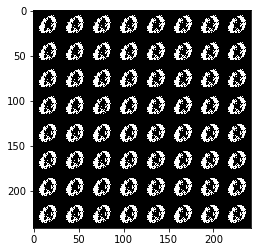

In [30]:
from PIL import Image
im = Image.open("results/fake_samples.png", "r")
plt.imshow(np.array(im))